In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from numpy import inf
from numbers import Number
from matplotlib.colors import LogNorm, Normalize

In [2]:
##Remove sequences with low quality reads

In [3]:
def filter_by_quality(path, filenames, quality_cutoff, rounds):
    uploaded_files = []
    
    for file in filenames:
        uploaded_files.append(open(path+file).readlines())

    all_seqs = []
    all_high_qual_seqs=[]

    for file in range(rounds):
        print(file)
        quality = uploaded_files[file][3::4]
        seqs = uploaded_files[file][1::4]

        all_seqs.append(seqs)

        origonal_seqs = all_seqs
      
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        
        for seq in range(len(quality)):
            overlap=0
            for char in list(set(quality[seq]).intersection(acceptable_quals_1_percent_error)):
                  overlap+=quality[seq].count(char)

            if overlap/len(quality[1]) > quality_cutoff/100:
                  high_quality.append(seqs[seq].strip("\n"))
            
        all_high_qual_seqs.append(high_quality)
    return all_high_qual_seqs, all_seqs

In [4]:
filenames = ['ppp-1_S1_L001_R2_001.fastq',
             'ppp-2_S2_L001_R2_001.fastq',
             'ppp-3_S3_L001_R2_001.fastq',
             'ppp-4_S4_L001_R2_001.fastq',
             'ppp-5_S5_L001_R2_001.fastq',
             'ppp-6_S6_L001_R2_001.fastq']

path_to_files = 'raw_data/'
all_high_qual_seqs, all_seqs = filter_by_quality(path_to_files, filenames, 90, 6)


0
1
2
3
4
5


In [5]:
##Trim to include only the 40nt randomized region inside the correct constant region

In [6]:
def filter_sequences_32nt(sequences):
    bp1 = 'ACTCACTGACACAGATCCACTCACGGACAGCG'
    bp2 = 'CGCTGTCC'
    bp1_len = len(bp1)
    bp2_len = len(bp2)
    spacer_len = 40

    filtered_sequences = []
    
    for seq in sequences:
        start_bp1 = seq.find(bp1)
        if start_bp1 != -1:
            start_bp2 = seq.find(bp2, start_bp1 + bp1_len + spacer_len)
            if start_bp2 == start_bp1 + bp1_len + spacer_len:
                filtered_sequences.append(seq[start_bp1+bp1_len:bp1_len+start_bp1+spacer_len])
    
    return filtered_sequences

In [7]:
all_high_qual_seqs_trimmed_32nt = []

for round_seqs in all_high_qual_seqs:
    print(all_high_qual_seqs.index(round_seqs))
    all_high_qual_seqs_trimmed_32nt.append(filter_sequences_32nt(round_seqs))

0
1
2
3
4
5


In [8]:
##Check how many sequences were kept at each step

In [9]:
summary_stats = pd.DataFrame(columns = ['Total', 'High quality'])
for round_num in range(len(all_seqs)):
    summary_stats.loc[round_num+1]=(len(all_seqs[round_num]), len(all_high_qual_seqs[round_num]))


In [10]:
#Plot number of sequences each distance from RS1 for each round and plot heatmap

1
2
3
4
5
6


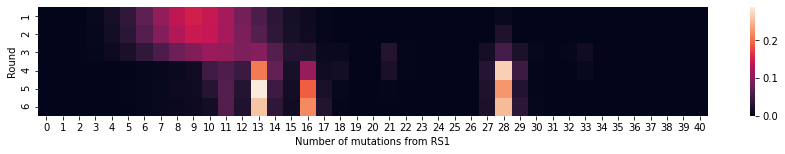

In [12]:
rs1 = 'GAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCT'

heatmap_mutation_data = []
for round in range(1,7):
    print(round)
    
    raw_seqs = all_high_qual_seqs_trimmed_32nt[round-1]

    seqs = raw_seqs
    
    distances = []
    for seq in seqs:
        distances.append(sum([1 for x, y in zip(rs1, seq) if x.lower() != y.lower()]))
    distances_counted = dict(Counter(distances))

    labels = [x[0] for x in list(distances_counted.items())]
    for i in list((set(labels)^set(range(41)))):
        distances_counted[i]=0
    mutations = [x[1] for x in sorted(distances_counted.items())]

    heatmap_mutation_data.append(np.array(mutations)/len(seqs))

plt.figure(figsize=(15,2))
yticklabels = range(1,7)
sns.heatmap(heatmap_mutation_data,yticklabels=yticklabels)
plt.ylabel('Round')
plt.xlabel('Number of mutations from RS1')
plt.savefig('../figures/mutations_from_rs1.jpg', dpi=600)

In [13]:
#Find the abundance of the sequences with >100 reads in CS3 over all rounds

1
2
3
4
5
6


<ipython-input-15-eea5801614a7>:24: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(heatmap_data), vmin = 0, yticklabels = range(1,7), xticklabels = range(1,69))


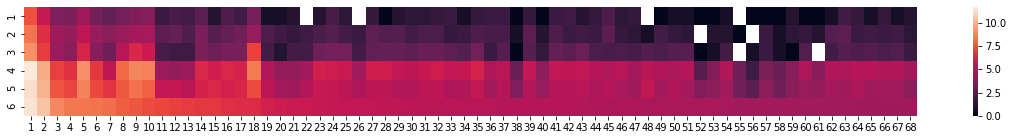

In [15]:
#Find sequences with >100 reads in CS3
data = pd.read_csv('../data/ppp_clusters.csv')
cs3_cluster = data[data.Cluster==5]
cs3_cluster_g100 = list(cs3_cluster[cs3_cluster.Reads>100].Seq)

#Track their reads by round
heatmap_data = []
for round in range(1,7):
    print(round)
    raw_seqs = all_high_qual_seqs_trimmed_32nt[round-1]
    
    seq_data = []
    for seq in cs3_cluster_g100:
        if seq in raw_seqs:
            reads = raw_seqs.count(seq)
        else:
            reads = 0
        seq_data.append(reads)
    heatmap_data.append(seq_data)
    
plt.figure(figsize=(20,2))
plt.ylabel('Round')
plt.xlabel('Number of mutations from RS1')
sns.heatmap(np.log(heatmap_data), vmin = 0, yticklabels = range(1,7), xticklabels = range(1,69))
plt.savefig('../figures/mutations_in_cs3_cluster.jpg', dpi=600)